# Decide threshold

The goal of this notebook is to define a threshold to determine if a sample if PAO1 or not (likewise, if a sample is PA14 or not). We used known labels from SRA to do this. Specifically, we examined the distribution of PAO1 samples (grey) vs non-PAO1 samples (blue). We define the threshold to be one that separated between the two distributions. We use this threshold in [2_create_compendia.ipynb](2_create_compendia.ipynb) to partition gene expression data into PAO1 and PA14 compendia.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
from textwrap import fill
import matplotlib.pyplot as plt
from scripts import paths, utils

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Raw (normalized counts) expression data files
pao1_expression_filename = paths.PAO1_GE
pa14_expression_filename = paths.PA14_GE

# File containing table to map sample id to strain name
sample_to_strain_filename = paths.SAMPLE_TO_STRAIN

In [3]:
# Load expression data
pao1_expression = pd.read_csv(pao1_expression_filename, sep="\t", index_col=0, header=0)
pa14_expression = pd.read_csv(pa14_expression_filename, sep="\t", index_col=0, header=0)

In [4]:
# Load metadata
# Set index to experiment id, which is what we will use to map to expression data
sample_to_strain_table_full = pd.read_csv(sample_to_strain_filename, index_col=2)

In [5]:
threshold = 25

pao1_dist_filename = (
    f"dist_median_acc_expression_pao1_compendium_{threshold}threshold.svg"
)
pa14_dist_filename = (
    f"dist_median_acc_expression_pa14_compendium_{threshold}threshold.svg"
)

## Format SRA annotations

In [6]:
# Since experiments have multiple runs there are duplicated experiment ids in the index
# We will need to remove these so that the count calculations are accurate
sample_to_strain_table_full_processed = sample_to_strain_table_full[
    ~sample_to_strain_table_full.index.duplicated(keep="first")
]

assert (
    len(sample_to_strain_table_full.index.unique())
    == sample_to_strain_table_full_processed.shape[0]
)

In [7]:
# Aggregate boolean labels into a single strain label
aggregated_label = []
for exp_id in list(sample_to_strain_table_full_processed.index):
    if sample_to_strain_table_full_processed.loc[exp_id, "PAO1"].all() == True:
        aggregated_label.append("PAO1")
    elif sample_to_strain_table_full_processed.loc[exp_id, "PA14"].all() == True:
        aggregated_label.append("PA14")
    elif sample_to_strain_table_full_processed.loc[exp_id, "PAK"].all() == True:
        aggregated_label.append("PAK")
    elif (
        sample_to_strain_table_full_processed.loc[exp_id, "ClinicalIsolate"].all()
        == True
    ):
        aggregated_label.append("Clinical Isolate")
    else:
        aggregated_label.append("NA")

sample_to_strain_table_full_processed["Strain type"] = aggregated_label

sample_to_strain_table = sample_to_strain_table_full_processed["Strain type"].to_frame()

sample_to_strain_table.head()

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Strain type
Experiment,
SRX5057740,NA
SRX5057739,NA
SRX5057910,NA
SRX5057909,NA
SRX3573046,PAO1


## Label samples with SRA annotations

In [8]:
# Label samples with SRA annotations
# pao1_expression_label = pao1_expression_binned.join(
#    sample_to_strain_table, how='left')
pao1_expression_label = pao1_expression.merge(
    sample_to_strain_table, left_index=True, right_index=True
)
pa14_expression_label = pa14_expression.merge(
    sample_to_strain_table, left_index=True, right_index=True
)
print(pao1_expression_label.shape)
pao1_expression_label.head()

(2333, 5564)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1,Strain type
ERX541571,5621.037929,902.172829,1380.825635,1811.863764,140.337996,508.725234,483.664878,666.605479,681.641693,77.687105,...,97.735390,471.134699,12.530178,87.711247,75.181069,77.687105,2288.010535,250.603564,0.000000,NA
ERX541572,6323.898054,835.453446,1754.599065,1814.798699,190.876886,418.460865,321.554138,493.343336,666.600816,45.516796,...,80.755606,487.470201,10.277986,70.477619,46.985080,60.199633,2218.576726,199.686588,0.000000,NA
ERX541573,4954.119979,893.818410,1984.802645,1752.146970,350.955170,362.785119,373.300630,465.311348,616.471815,42.062043,...,114.356179,782.091108,19.716583,153.789344,43.376482,106.469546,1474.800376,101.211790,0.000000,NA
ERX541574,4603.356163,773.573295,2227.891090,1911.321096,311.809544,323.710671,435.581271,435.581271,506.988037,78.547442,...,152.334434,561.733224,21.422030,85.688119,38.083608,64.266089,2116.020491,78.547442,2.380226,NA
ERX541575,4260.451254,875.408119,2140.106080,1788.361959,320.126671,288.509222,276.652679,577.018444,739.057871,57.306626,...,136.350249,677.799063,15.808725,195.632966,21.736996,118.565434,1650.035620,61.258807,0.000000,NA


In [9]:
print(pa14_expression_label.shape)
pa14_expression_label.head()

(2333, 5892)


,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845,Strain type
ERX541571,209.353167,55.650842,0.000000,2.650040,10.600160,10.600160,18.550281,71.551082,66.251002,5.300080,...,140.452125,3487.452760,180.202726,21.200321,2.650040,1014.965355,386.905853,151.052285,0.0,NA
ERX541572,223.627085,52.077540,6.126769,15.316924,21.443693,9.190154,12.253539,79.648003,82.711388,3.063385,...,180.739699,2977.609951,223.627085,27.570463,15.316924,1203.910196,572.852943,119.472004,0.0,NA
ERX541573,167.343061,44.624816,18.128832,23.706934,8.367153,18.128832,5.578102,64.148173,57.175546,8.367153,...,207.784301,1811.488635,68.331750,4.183577,12.550730,1540.950687,616.380275,62.753648,0.0,NA
ERX541574,203.038931,13.454387,6.115630,14.677513,4.892504,17.123765,8.561883,47.701918,58.710052,7.338757,...,226.278327,2239.543876,77.056944,6.115630,12.231261,1700.145269,895.328300,165.122023,0.0,NA
ERX541575,193.971582,46.384509,8.433547,29.517415,8.433547,12.650321,4.216774,44.276122,42.167735,6.325160,...,250.898025,1574.964910,65.359990,4.216774,10.541934,1313.524952,710.526338,145.478686,0.0,NA


## Get accessory gene expression

In [10]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

core_acc_dict = utils.get_my_core_acc_genes(
    pao1_annot_filename, pa14_annot_filename, pao1_expression, pa14_expression
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5361
Number of PAO1-specific genes: 202
Number of PA14-specific genes: 530


In [11]:
pao1_acc = core_acc_dict["acc_pao1"]
pa14_acc = core_acc_dict["acc_pa14"]

In [12]:
# Create accessory df
# accessory gene ids | median accessory expression | strain label

# PAO1
pao1_acc_expression = pao1_expression_label[pao1_acc]
pao1_acc_expression["median_acc_expression"] = pao1_acc_expression.median(axis=1)

# PA14
pa14_acc_expression = pa14_expression_label[pa14_acc]
pa14_acc_expression["median_acc_expression"] = pa14_acc_expression.median(axis=1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [13]:
# Add back labels
pao1_acc_expression["Strain type"] = pao1_expression_label["Strain type"]
pa14_acc_expression["Strain type"] = pa14_expression_label["Strain type"]

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
pao1_acc_expression.head()

,PA0095,PA2224,PA2294,PA2192,PA3497,PA1382,PA3155,PA2105,PA3158,PA2074,...,PA2184,PA5253,PA2853,PA4194,PA1383,PA2727,PA3153,PA4106,median_acc_expression,Strain type
ERX541571,1248.005746,177.928530,17.542249,2.506036,117.783675,498.701091,2232.877751,107.759532,2759.145234,12.530178,...,2.506036,506.219198,82385.921501,7.518107,388.435523,112.771604,1200.391069,25.060356,90.217283,NA
ERX541572,1018.988913,118.930983,4.404851,4.404851,89.565308,694.498207,1641.541218,80.755606,2446.160705,14.682837,...,13.214554,678.347086,84860.926848,14.682837,409.651163,162.979495,1701.740851,24.960824,88.097024,NA
ERX541573,1073.896530,76.237453,7.886633,1.314439,65.721942,891.189532,1125.159645,90.696280,2112.303212,13.144388,...,18.402144,906.962798,65650.962180,11.829950,478.455737,201.109142,2314.726793,51.263115,91.353499,NA
ERX541574,685.504951,142.813531,14.281353,7.140677,90.448570,918.767052,1094.903741,121.391502,2432.590485,9.520902,...,16.661579,509.368262,49256.386988,19.041804,464.143977,288.007288,2899.114688,38.083608,103.539810,NA
ERX541575,901.097297,86.947985,13.832634,1.976091,90.900166,796.364497,1365.478579,75.091441,1999.803650,7.904362,...,33.593540,964.332195,70728.233426,23.713087,460.429101,270.724407,2412.806577,59.282717,82.995804,NA


In [15]:
pa14_acc_expression.head()

,PA14_04010,PA14_37170,PA14_16110,PA14_31130,PA14_28840,PA14_22600,PA14_31060,PA14_13200,PA14_27650,PA14_03290,...,PA14_67900,PA14_22510,PA14_22130,PA14_59370,PA14_58970,PA14_55240,PA14_22100,PA14_15630,median_acc_expression,Strain type
ERX541571,66.251002,7.950120,53.000802,0.000000,5.300080,23.850361,0.000000,0.000000,0.000000,37.100561,...,58.300882,0.000000,0.0,5.30008,0.000000,159.002405,0.0,0.000000,0.000000,NA
ERX541572,183.803083,24.507078,27.570463,94.964926,0.000000,21.443693,0.000000,0.000000,12.253539,76.584618,...,94.964926,6.126769,0.0,0.00000,0.000000,162.359390,0.0,6.126769,3.063385,NA
ERX541573,217.545979,22.312408,40.441240,2.789051,2.789051,15.339781,0.000000,2.789051,0.000000,129.690872,...,139.452551,0.000000,0.0,0.00000,0.000000,225.913132,0.0,0.000000,1.394526,NA
ERX541574,266.641488,6.115630,31.801278,0.000000,1.223126,24.462522,0.000000,0.000000,0.000000,116.196979,...,178.576410,0.000000,0.0,0.00000,1.223126,207.931436,0.0,0.000000,1.223126,NA
ERX541575,206.621903,25.300641,29.517415,0.000000,4.216774,25.300641,4.216774,0.000000,0.000000,128.611592,...,107.527725,0.000000,0.0,0.00000,4.216774,288.848986,0.0,2.108387,2.108387,NA


In [16]:
# Merge PAO1 and PA14 accessory dataframes
pao1_pa14_acc_expression = pao1_acc_expression.merge(
    pa14_acc_expression,
    left_index=True,
    right_index=True,
    suffixes=["_pao1", "_pa14"],
)

pao1_pa14_acc_expression.head()

,PA0095,PA2224,PA2294,PA2192,PA3497,PA1382,PA3155,PA2105,PA3158,PA2074,...,PA14_67900,PA14_22510,PA14_22130,PA14_59370,PA14_58970,PA14_55240,PA14_22100,PA14_15630,median_acc_expression_pa14,Strain type_pa14
ERX541571,1248.005746,177.928530,17.542249,2.506036,117.783675,498.701091,2232.877751,107.759532,2759.145234,12.530178,...,58.300882,0.000000,0.0,5.30008,0.000000,159.002405,0.0,0.000000,0.000000,NA
ERX541572,1018.988913,118.930983,4.404851,4.404851,89.565308,694.498207,1641.541218,80.755606,2446.160705,14.682837,...,94.964926,6.126769,0.0,0.00000,0.000000,162.359390,0.0,6.126769,3.063385,NA
ERX541573,1073.896530,76.237453,7.886633,1.314439,65.721942,891.189532,1125.159645,90.696280,2112.303212,13.144388,...,139.452551,0.000000,0.0,0.00000,0.000000,225.913132,0.0,0.000000,1.394526,NA
ERX541574,685.504951,142.813531,14.281353,7.140677,90.448570,918.767052,1094.903741,121.391502,2432.590485,9.520902,...,178.576410,0.000000,0.0,0.00000,1.223126,207.931436,0.0,0.000000,1.223126,NA
ERX541575,901.097297,86.947985,13.832634,1.976091,90.900166,796.364497,1365.478579,75.091441,1999.803650,7.904362,...,107.527725,0.000000,0.0,0.00000,4.216774,288.848986,0.0,2.108387,2.108387,NA


## Plot distribution

In [17]:
# Get PAO1 samples that are labeled PAO1 and non-PAO1
pao1_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pao1"] == "PAO1",
    "median_acc_expression_pao1",
]

non_pao1_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pao1"] != "PAO1",
    "median_acc_expression_pao1",
]

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


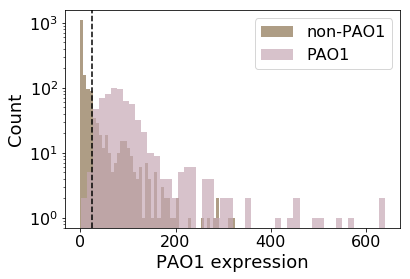

In [18]:
f = sns.distplot(
    non_pao1_sra,
    color="#795C34",
    label="non-PAO1",
    kde=False,
    hist_kws={
        "alpha": 0.6,
    },
)
f = sns.distplot(
    pao1_sra, color="#C6A9B5", label="PAO1", kde=False, hist_kws={"alpha": 0.7}
)
plt.axvline(threshold, color="black", linestyle="--")
f.set_yscale("log")
f.set_ylabel("Count", fontsize=18)
f.set_xlabel("PAO1 expression", fontsize=18)
f.tick_params(labelsize=16)
plt.legend(fontsize=16)

f.figure.savefig(pao1_dist_filename, bbox_inches="tight", format="svg", dpi=300)

In [19]:
# Get PA14 samples that are labeled PA14 and non-PA14
pa14_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pa14"] == "PA14",
    "median_acc_expression_pa14",
]

non_pa14_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pa14"] != "PA14",
    "median_acc_expression_pa14",
]

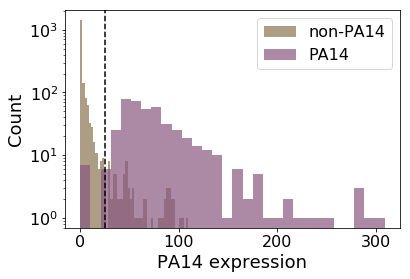

In [20]:
g = sns.distplot(
    non_pa14_sra,
    color="#795C34",
    label="non-PA14",
    kde=False,
    hist_kws={"alpha": 0.6},
)
g = sns.distplot(
    pa14_sra,
    color="#895881",
    label="PA14",
    kde=False,
    hist_kws={"alpha": 0.7},
)

plt.axvline(threshold, color="black", linestyle="--")
g.set_yscale("log")
g.set_ylabel("Count", fontsize=18)
g.set_xlabel("PA14 expression", fontsize=18)
g.tick_params(labelsize=16)
plt.legend(fontsize=16)
g.figure.savefig(pa14_dist_filename, bbox_inches="tight", format="svg", dpi=300)

**Takeaway:**
Looks like using a threshold of 25 normalized counts separates between SRA-annotated PAO1 samples vs non-PAO1 samples. Similarly for PA14. This is the threshold we'll use to bin samples into PAO1 vs PA14 compendia.